In [1]:
import cudf
import pandas as pd
import numpy as np
import time

/nvme/0/pgali/envs/cudfdev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)

In [3]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 10_000_00, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=10_000_00)
})

In [4]:
pdf

,numbers,business
0,-316,Costco
1,-441,Walmart
2,653,Buckees
3,216,Buckees
4,-165,Costco
...,...,...
999995,309,Buckees
999996,-748,Walmart
999997,-615,Walmart
999998,-590,Costco


In [5]:
gdf = cudf.from_pandas(pdf)

In [6]:
gdf

,numbers,business
0,-316,Costco
1,-441,Walmart
2,653,Buckees
3,216,Buckees
4,-165,Costco
...,...,...
999995,309,Buckees
999996,-748,Walmart
999997,-615,Walmart
999998,-590,Costco


In [7]:
def time_it(callable):
    start = time.time()
    callable()
    end = time.time()
    return end - start

In [8]:
start = time.time()
pdf.to_parquet("pandas.parquet")
end = time.time()

In [9]:
pandas_to_parquet = time_it(lambda : pdf.to_parquet("pandas.parquet"))

In [10]:
cudf_to_parquet = time_it(lambda : gdf.to_parquet("cudf.parquet"))

In [11]:
pandas_read_parquet = time_it(lambda : pd.read_parquet("pandas.parquet"))

In [12]:
cudf_read_parquet = time_it(lambda : cudf.read_parquet("cudf.parquet"))

In [13]:
pandas_to_csv = time_it(lambda : pdf.to_csv("pandas.csv"))

In [14]:
cudf_to_csv = time_it(lambda : gdf.to_csv("cudf.csv"))

In [15]:
pandas_read_csv = time_it(lambda : pd.read_csv("pandas.csv"))

In [16]:
cudf_read_csv = time_it(lambda : cudf.read_csv("cudf.csv"))

In [17]:
pandas_groupby = time_it(lambda : pdf.groupby("business").agg(["min", "max", "mean"]))

In [18]:
cudf_groupby = time_it(lambda : gdf.groupby("business").agg(["min", "max", "mean"]))

In [21]:
pandas_merge = time_it(lambda : pdf.merge(pdf))

In [22]:
cudf_merge = time_it(lambda : gdf.merge(gdf))

0.007723569869995117

In [25]:
import matplotlib.pyplot as plt

In [53]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_to_parquet/cudf_to_parquet, pandas_read_parquet/cudf_read_parquet, pandas_to_csv/cudf_to_csv, pandas_read_csv/cudf_read_csv, pandas_groupby/cudf_groupby, pandas_merge/cudf_merge],
}, index=["to_parquet", "read_parquet", "to_csv", "read_csv", "groupby", "merge"])

In [54]:
perf_df

,cudf speed up v/s pandas
to_parquet,3.280908
read_parquet,6.536486
to_csv,32.013847
read_csv,10.198759
groupby,12.964539
merge,8.535013


[Text(0, 0, '3.28091'),
 Text(0, 0, '6.53649'),
 Text(0, 0, '32.0138'),
 Text(0, 0, '10.1988'),
 Text(0, 0, '12.9645'),
 Text(0, 0, '8.53501')]

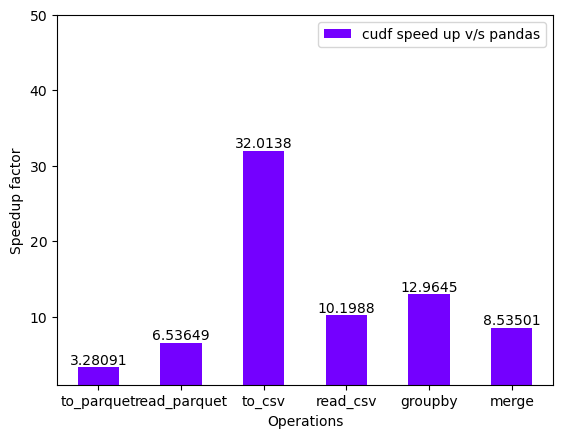

In [58]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,50), rot=0)
ax.set_xlabel("Operations")
ax.set_ylabel("Speedup factor")
ax.bar_label(ax.containers[0])

In [33]:
pd_series = pd.Series(np.random.choice(["123", "56.234", "Walmart", "Costco", "rapids ai"], size=10_000_000))

In [34]:
gd_series = cudf.from_pandas(pd_series)

In [35]:
pandas_upper = time_it(lambda : pd_series.str.upper())

In [36]:
cudf_upper = time_it(lambda : gd_series.str.upper())

In [40]:
pandas_contains = time_it(lambda : pd_series.str.contains(r"[0-9][a-z]"))

In [41]:
cudf_contains = time_it(lambda : gd_series.str.contains(r"[0-9][a-z]"))

In [42]:
pandas_isalpha = time_it(lambda : pd_series.str.isalpha())

In [43]:
cudf_isalpha = time_it(lambda : gd_series.str.isalpha())

In [51]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_upper/cudf_upper, pandas_contains/cudf_contains, pandas_isalpha/cudf_isalpha,],
}, index=["upper", "contains", "is_alpha",])

[Text(0, 0, '93.1188'), Text(0, 0, '68.6325'), Text(0, 0, '293.558')]

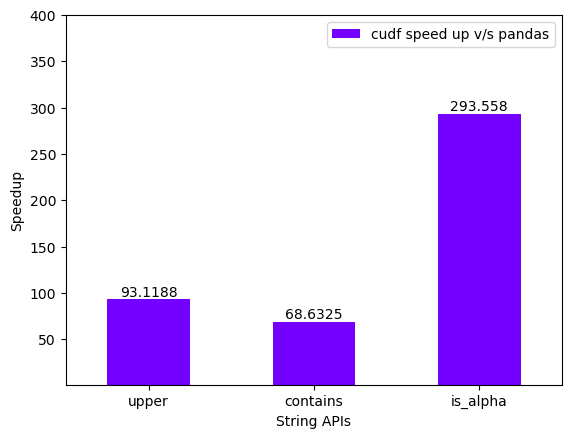

In [52]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,400), rot=0)
ax.set_xlabel("String APIs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])

## UDF